In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import math
import random
# import cv2 as cv
%matplotlib inline

# Meteo Webcam Analysis

The goal of this project is to analyze webcam capture images from [meteo.physic.ut.ee](https://meteo.physic.ut.ee/) and practice applying different analysis methods on the data. 
All images used here are downloaded from the [archive](https://meteo.physic.ut.ee/webcam/uus/archive/). Thank you to the Laboratory of Environmental Physics in University of Tartu (Institute of Physics) for keeping this archive open and free to use.

Ideas:
- Skies only (top 310 pixels).
- Cars in the parking lot.
- Weather, duration of days, light.
- People.
- Lights in the buildings.

Video clips of the archived footage can be found in the same location as the images, or in the form of a timelapse: [2019](https://youtu.be/q_ZRND_3uQY) and [2020](https://youtu.be/9cNdEs1fOOQ).

## Skies

Create a dataset of the sky only.

In [2]:
def create_skies(resize_n, path_from, path_to):
    for month in os.listdir(path_from):
        for hour in os.listdir(path_from + month):
            img_arr = np.array(Image.open(path_from + month + '/' + hour))
            
            # Trim, keep the sky
            img_trimmed = img_arr[:310,:]
            
            # Resize by n (given as arg)
            img_resized = img_trimmed[::resize_n, ::resize_n]
            
            # Save image
            path = path_to + hour[:13] + '.jpg'
            plt.imsave(path, img_resized)
            

# The raw data folders included .jpg images from the webcam archive
for year in ['data/raw/2020/', 'data/raw/2019/']:
    create_skies(5, year, 'data_256/')
    create_skies(2, year, 'data_640/')

FileNotFoundError: [Errno 2] No such file or directory: 'data_640/2020-03-08T05.jpg'

In [50]:
folder = 'data/256/' # Skies downscaled 5x
num_of_imgs = len(os.listdir(folder)[:2500])
width = 256
height = 62

data = np.ndarray(shape=(num_of_imgs, height, width, 3), dtype=np.float32)
full_labels = np.ndarray(shape=(num_of_imgs), dtype=object)
labels = np.ndarray(shape=(num_of_imgs), dtype=np.uint8)

data.shape, labels.shape

((2500, 62, 256, 3), (2500,))

In [51]:
# Load the images from disk (check RAM!)
for i,file in enumerate(os.listdir(folder)[:2500]): 
    img = Image.open(folder + file)
    data[i] = img
    
    img_normal = data[i].astype(np.float32)
    img_normal /= 255.0
    data[i] = img_normal
    # Todo normalize further
    
    date = file[5:-4].replace('-','').replace('T','')
    full_labels[i] = date
    labels[i] = int(date[4:])

1. 15
2. 23
3. 6


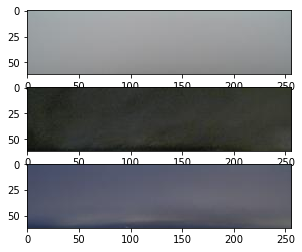

In [52]:
# Image preview
nums = [random.randint(0,len(data)) for i in range(3)]

_, ax = plt.subplots(len(nums), 1)
for i,num in enumerate(nums):
    print(f'{i+1}. {labels[num]}')
    ax[i].imshow(data[num])
    
plt.show()

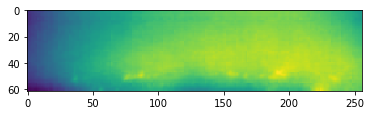

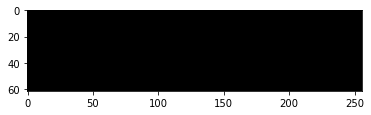

In [53]:
# Average of colors
plt.imshow(np.mean(data, axis=(0,3)))
plt.show()
plt.imshow(np.average(data, axis=0).astype(np.uint8))
plt.show()

In [62]:
# Average pixel values for each day
df = pd.DataFrame({"pixel_avg": [np.mean(data[i], axis=(0,1,2)) for i in range(len(data))], 
                   "month": [int(lbl[:2]) for lbl in full_labels], 
                   "day": [int(lbl[2:4]) for lbl in full_labels],
                   "hour": labels})
df

,pixel_avg,month,day,hour
0,0.238807,1,1,0
1,0.291661,1,1,1
2,0.234015,1,1,2
3,0.299324,1,1,3
4,0.325750,1,1,4
...,...,...,...,...
2495,0.014665,4,14,23
2496,0.013981,4,15,0
2497,0.016112,4,15,1
2498,0.472028,4,15,2


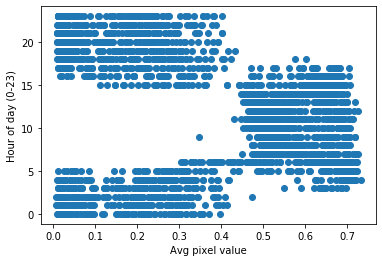

In [63]:
plt.plot(df.pixel_avg, df.hour, 'o')
plt.xlabel('Avg pixel value')
plt.ylabel('Hour of day (0-23)')
plt.show()

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import  accuracy_score, max_error, mean_squared_error


# Data split
X = df.drop('pixel_avg', axis=1)
y = df.pixel_avg
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=33)

# The models
model = KNeighborsRegressor(n_neighbors=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ...

print("X values:", X_test[1])
print("Real y:", y_test[1])
print("Predicted y:", y_pred[1])
print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))

X values: [ 1 12 13]
Real y: 0.5706486701965332
Predicted y: 0.5080279057676141
RMSE: 0.1076


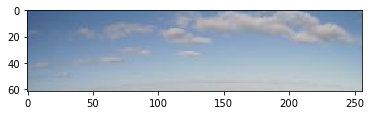

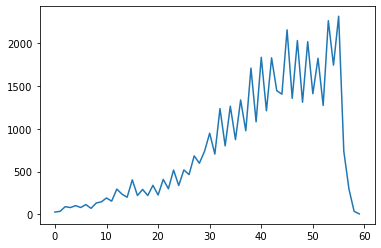

In [56]:
# Histogram of color values
num = 1333
hist, _ = np.histogram(data[num], bins=60)
plt.imshow(data[num])
plt.show()
plt.plot(hist)
plt.show()

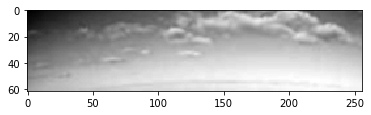

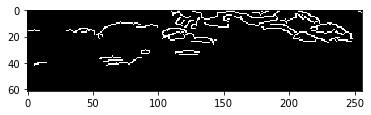

In [61]:
# Edge detection for clouds
gray = cv.cvtColor(data[num], cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray,(3,3),0)
blur = (blur*255).astype(np.uint8)

plt.imshow(blur, cmap = 'gray')
plt.show()

edges = cv.Canny(blur, 20, 50)
plt.imshow(edges, cmap = 'gray')
plt.show()